In [460]:
import networkx as nx
import numpy as np
import os
import csv
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import random
import collections
import math
from __future__ import division
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import re
import pylab
import operator
import ast
from itertools import chain
from collections import defaultdict
import math

%matplotlib inline

# Plot graph

In [461]:

def plot_graph(G: nx.Graph, has_pos=False, dest_file: str = None, labels=False, color='PuRd', title=None,
               node_size_multiplier=1, invert_color=False, graph_type='circular'):
    """

    :param G:
    :param has_pos:
    :param dest_file:
    :param labels:
    :param color: One of the color maps here: https://matplotlib.org/tutorials/colors/colormaps.html
    :param title:
    :return:
    """
    plt.figure(figsize=(25.6, 19.2))
    mapping = dict(
        [(n, '\n'.join(n.split()) + '\n' + str(w)) for n, w in nx.get_node_attributes(G, 'weight').items()])
    G1 = nx.relabel_nodes(G, mapping=mapping)
#     G1 = G
    node_colors = ['yellow' for node in G1.nodes()]
    #node_size = 5000 * node_size_multiplier
    node_size = list(nx.get_node_attributes(G1, 'weight').values())
    node_size = [x*100 * node_size_multiplier for x in node_size]
    node_colors = list(nx.get_node_attributes(G1, 'weight').values())
    edge_cmap = plt.get_cmap(color)
    edge_colors = list(nx.get_edge_attributes(G1, 'weight').values())
    node_cmap = plt.get_cmap('YlOrRd')
    node_colors = list(nx.get_node_attributes(G1, 'weight').values())
    if invert_color:
        max_weight = max(edge_colors)
        edge_colors = [max_weight - v for v in edge_colors]
    if has_pos:
        pos = nx.get_node_attributes(G1, 'pos')
    else:
        if graph_type == 'circular':
            pos = nx.drawing.layout.circular_layout(G1)
        else:
            pos = nx.drawing.kamada_kawai_layout(G1)
            if len(G.nodes()) > 25:
                k = 2
                iterations = 30
            else:
                k = 5
                iterations = 50
            pos = nx.drawing.layout.spring_layout(G1, pos=pos, iterations=iterations, k=k)
            pos = nx.drawing.layout.spring_layout(G1, iterations=iterations, k=k)

    # https://matplotlib.org/tutorials/colors/colormaps.html
    nx.draw_networkx(G1, pos=pos, node_size=node_size, width=20, alpha=0.5, node_color=node_colors,
                     edge_color=edge_colors, with_labels=labels, cmap=node_cmap,
                     edge_cmap=edge_cmap)

    if labels:
        edge_labels = nx.get_edge_attributes(G1, 'weight')
        nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()
    if dest_file:
        plt.savefig(dest_file)


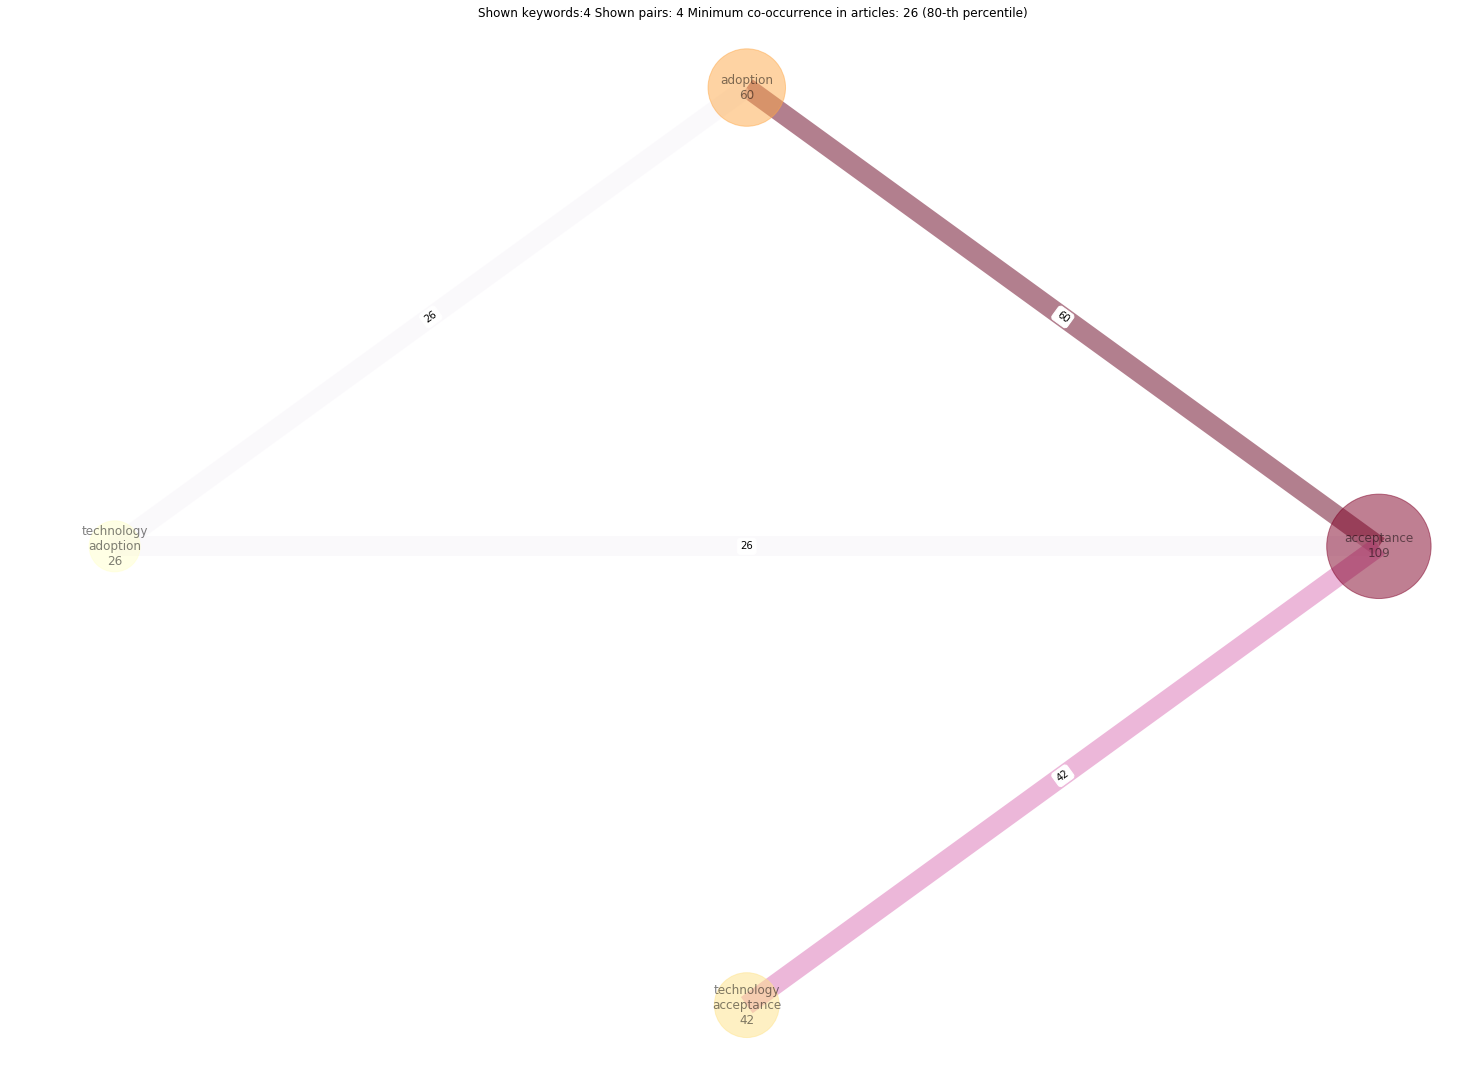

<Figure size 432x288 with 0 Axes>

In [518]:
create_graph(articles=articles, property_="concerns", year1=2010,year2=2012)

# Read files

In [462]:
def read_files(filename, property_groups, type_sepparation):
    articles = pd.read_csv(filename, sep=type_sepparation, index_col=0, header=0)
    properties_file = pd.read_csv(property_groups, sep=type_sepparation, header=0)
    properties = list(properties_file[properties_file.columns[0]])
    for p in properties:
        articles[p] = articles[p].fillna('')
    
    return articles, properties

In [484]:
def split_in_groups(min_year,max_year,num_intervals):
    step = math.ceil((max_year-min_year+1)/num_intervals)
    list_years = [(x,y) for x,y in zip(range(min_year,max_year+1, step),
                                       range(min_year+step-1,max_year+1,step))]
    tp = ()
    if len(list_years)!=num_intervals:
        if list_years[len(list_years)-1][1]-max_year==1:
            list_years.append((max_year, max_year))
        else:
            list_years.append(tuple(range(list_years[len(list_years)-1][1]+1, max_year+1,1)))
    
    for n, i in enumerate(list_years):
        if i == ():
            print("Number of intervals not supported, empty touple occures. Choose different number. For example try a number divisible by the number of years.")
            return
        elif len(i)==1:
            list_years[n] = (list_years[n][0],list_years[n][0])
    return list_years

# Show Graphs

In [517]:
def create_graph(year1,year2,property_, articles):

    property_pairs = OrderedDict()
    properties = {}
    for index, row in articles.iterrows():
        vals = row[property_].split(',')
        if row['year']>= year1 and row['year']<= year2: #za poveke godini (in)
            found_props = []
            for prop in vals:
                found_props.append(prop)
                properties.setdefault(prop, 0)
                properties[prop] += 1
            found_props.sort()
            for i in range(len(found_props) - 1):
                for j in range(i + 1, len(found_props)):
                    pair_key = (found_props[i], found_props[j])
                    property_pairs.setdefault(pair_key, 0)
                    property_pairs[pair_key] += 1
                    
    G = nx.Graph()
    
    edge_weights = list(property_pairs.values())
    thr_percentile = 80
    edge_weights_thres = int(np.percentile(edge_weights, thr_percentile))
    selected_properties = set()
    
    for (property1, property2), weight in property_pairs.items():
        if weight >= edge_weights_thres:
            selected_properties.add(property1)
            selected_properties.add(property2)
            G.add_edge(property1, property2, weight=weight, tezina=weight)
    
    for prop, weight in properties.items():
        if prop in selected_properties:
            G.add_node(prop, weight=weight, tezina=weight)
        
    
    if '' in G: 
        G.remove_node('')
    
    title = 'Shown keywords:{0} Shown pairs: {1} Minimum co-occurrence in articles: {2} ({3}-th percentile)'.format(
        len(G.nodes()), len(G.edges), edge_weights_thres, thr_percentile)
    
    plot_graph(G, dest_file='graph_plot_concerns_2010_2012_properties_circular.png', labels=True, title=title,
               graph_type='circular', node_size_multiplier=1)
    return G


# Occurance of technology words

In [465]:
def take_prop_count_from_years(year1,year2,prop,articles):
    date_word = {}
    total_word = {}
    
    for index, row in articles.iterrows():
        year = row['year']
        if year >= year1 and year <= year2:
            technologies = row[prop].split(",")
            for t in technologies:
                if t!="":
                    if t in total_word:
                        total_word[t] += 1 
                    else:
                        total_word[t] = 1 
    
    return total_word

In [503]:
def plot_centVSpage(cent, pag, sizes, name, years):
    names = [str(str(b[0])+ "\n" + str(a)) for b,a in zip(cent, sizes)]
    x = [b for a,b in cent]
    if max(x)- min(x)!=0:
        x = [(a - sum(x)/len(x))/(max(x) - min(x)) for a in x]
    else:
        x = [(a - sum(x)/len(x)) for a in x]
    y = [b for a,b in pag]
    if max(y)- min(y)!=0:
        y = [(a - sum(y)/len(y))/(max(y) - min(y)) for a in y]
    else:
        y = [(a - sum(y)/len(y)) for a in y]
    colors = np.asarray(sizes)
    fig, ax = plt.subplots()
    fig.set_size_inches((10,10))
    ax.scatter(x,y, c = colors, s = np.asarray(sizes), alpha = 0.3)
    ax.axvline(0)
    ax.axhline(0)
    ax.set_xlabel("CENTRALITY")
    ax.set_ylabel("PAGERANK")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(str(name)+'_'+ str(years[0])+'_'+ str(years[1]))
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    cmap = mpl.colors.Colormap("Size Bar", len(sizes))
    sm = ScalarMappable()
    sm.set_array(colors)
    fig.colorbar(mappable = sm,cmap = cmap)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0, width = 0)
    
    centar_dist = [math.sqrt((a**2+b**2)) for a,b in zip(x,y)]
    str_cent_dist = ""
    for c,(a,b) in zip(centar_dist, cent):
        str_cent_dist+= a + ": "+str(c)+"\n"
    ax.text(-0.5,-1.3, str("Distance from (0,0) coordinate: "+str_cent_dist))
    for i, txt in enumerate(names):
        ax.annotate(txt, (x[i],y[i]))
    #print('plot_centVSpage'+ '_'+str(name)+'.pdf')
    plt.savefig('plot_centVSpage'+ '_'+str(name)+'_'+ str(years[0])+'_'+ str(years[1])+'.pdf')
    return centar_dist

In [467]:
def plot_by_size(l_sizes, time_ranges, n_cols):
    fig, list_ax = plt.subplots(ncols = n_cols)
    fig.set_size_inches((10,20))
    for i, sizes in enumerate(l_sizes):
        names = [str(str(b)+ "\n" + str(a)) for b,a in sizes]
        x = [len(names)-ii for ii in range(len(names))]
        y = [0 for i in x]
        colors = np.asarray([b for a,b in sizes])
        
        list_ax[i].scatter( y,x, c = colors, s = [b for a,b in sizes], alpha = 0.3)
        
        list_ax[i].set_xlabel(time_ranges[i])
        list_ax[i].spines['bottom'].set_color('white')
        list_ax[i].spines['top'].set_color('white') 
        list_ax[i].spines['right'].set_color('white')
        list_ax[i].spines['left'].set_color('white')
        list_ax[i].xaxis.set_label_position('top')
        
        for j, txt in enumerate(names):
            list_ax[i].annotate(txt, (y[j],x[j]))
        
        plt.setp(list_ax[i].get_xticklabels(), visible=False)
        plt.setp(list_ax[i].get_yticklabels(), visible=False)
        list_ax[i].tick_params(axis='both', which='both', length=0, width = 0)
        
    plt.savefig('plot_by_weight_label_'+str(n_cols)+'.pdf')

In [468]:
def create_list_prop_years(list_prop_group, years):
    list_cent = []
    list_sizes = []
    list_pag = []
    list_s = []
    list_years = []
    list_properties = []
    for prop in list_prop_group:
        for year1,year2 in years:
            G = create_graph(articles=articles, property_=prop, year1=year1, year2=year2)
            centrality = nx.degree_centrality(G)
            pagerank = nx.pagerank(G)
            total_word = take_prop_count_from_years(year1,year2, prop, articles)
            cent = sorted(centrality.items())
            pag = sorted(pagerank.items())
            sizes = sorted(total_word.items())
            ss = []
            for l in list(G.nodes):
                ss.append(total_word[l])
            list_siz = {}
            for s in sizes:
                for c in cent:
                   # print(s[0],c[0])
                    if s[0]==c[0]:
                        if s[0] in list_siz:
                            list_siz[s[0]]+=s[1]
                        else:
                            list_siz[s[0]] = s[1]
                            
            list_years.append((year1,year2))
            list_cent.append(cent)
            list_sizes.append(list_siz)
            list_s.append(ss)
            list_pag.append(pag)
            list_properties.append(prop)

    list_list = [None]*len(years)
    for i in range(len(list_sizes)):
        ii = i%len(years)
        if list_list[ii] is None:
            list_list[ii] = [list_sizes[i]]
        else:
            list_list[ii].append(list_sizes[i])
    list_sizes = []
    for l in list_list:
        temp_dict = list_to_dict_summed_values(l)
        list_sizes.append(sorted(temp_dict.items(), key = operator.itemgetter(1), reverse = True))

    return (list_sizes, list_cent, list_pag, list_s, list_years, list_properties)


In [469]:
def list_to_dict_summed_values(list_sizes):
    dict_temp = defaultdict(list)
    if len(list_sizes)%2==0:
        for i in range(0,len(list_sizes),2):
            for k,v in chain(list_sizes[i].items(), list_sizes[i+1].items()):
                dict_temp[k].append(v)
    else:
        for i in range(0,len(list_sizes)-1,2):
            for k,v in chain(list_sizes[i].items(), list_sizes[i+1].items()):
                dict_temp[k].append(v)
        for k,v in chain(list_sizes[len(list_sizes)-1].items()):
                dict_temp[k].append(v)
        
    dict_ = {}
    for k, v in dict_temp.items():
        for i in v:
            if k in dict_:
                dict_[k] += i
            else:
                dict_[k] = i
    return dict_

#concerns 2010-2011
#da se provere brojot na krugovite greska imam so godinite
#da se zacuvuvat
#bez vrski
# da bide od -1->1 po 2te oski
# posle toa da bidat rangirani so dodavanje na +1 +1 na koordinatite na tockite i posle da se 
#presmeta dekartovo rastojanie od pocetok do tocka
#a, cent_list, pag_list, list_siz_list = create_list_prop_years(list_prop_group, years)
#print(len(cent_list), len(pag_list), len(list_siz_list))


In [507]:
def main():
    #vo read_files vnesi pateka na .csv so podatocite, pateka na .csv so property_groups(agg_prop_year)
    #i tipot na delimiter koj se koristi vo .csv fajlovite
    articles, names = read_files(
        'C:\\fakultet\\Sedmi semestar\\Virtuelni opstestva\\Proekt\\filtered_property_groups.csv',
        'C:\\fakultet\\Sedmi semestar\\Virtuelni opstestva\\Proekt\\aggr_property_year_pivot.csv',
        ",")
    print(articles.shape)
   # #izbirame broj na periodi dokolku e ne logicno da se podeli na tolkav broj periodi ke isprinta 
   # #error. Pr. dokolku imame vkupno 10 godini, a sakame da podelime vo 8 periodi, nema da dozvoli,
   # #no dokolku sakame da podelime na 4 ke dozvoli so toa sto posledniot period kje bide pokratok. 
   # num_intervals = 4
   # 
   # #sledno ke napravime plot po golemina na jazlite za sekoj period (brojot na periodi sami go birame)
   # years_from_article = sorted(set(articles['year']))
   # properties = list(set(names))
   # 
   # 
   # #kreirame lista od periodide
   # years = split_in_groups(max_year=years_from_article[-1],
   #                         min_year=years_from_article[0],
   #                         num_intervals=num_intervals)
   # print(years)
   # #lista od listi na torki za sumarna golemina na nodovi po periodi, 
   # #centralnost, pagerank, golemina na nodovi po property i period, periodite, propertiata 
   # list_sizes, list_cent, list_pag, list_s, list_years, list_properties = create_list_prop_years(list_prop_group=properties,
   #                                                                  years=years)
   # 
   # #iscrtuvanje na sortiranite nodovi podeleni vo brojot n periodi
   # plot_by_size(l_sizes=list_sizes,n_cols=num_intervals,time_ranges=years)
   # 
   # #iscrtuvanje na site Cetrality vs Pagerank plotovi so presmetani rastojanija od 
   # #koordinatniot pocetok
   # for cent, pag, sizes, name, year in zip(list_cent, list_pag, list_s, list_properties, years*len(list_cent)):
   #     plot_centVSpage(cent=cent, name=name, pag=pag, sizes=sizes, years=year)
   # 
    
    
    

In [508]:
main()

(2406, 22)
